In [ ]:
import zipfile
import requests
import cv2
import matplotlib.pyplot as plt
import glob
import random
import os

## Установка пакета Ultralytics

In [ ]:
!pip install ultralytics==8.0.20

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 261.2/261.2 kB 1.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 264.9/264.9 kB 15.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 23.7/23.7 MB 29.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 823.6/823.6 kB 30.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 14.1/14.1 MB 34.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 731.7/731.7 MB 1.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 410.6/410.6 MB 1.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 121.6/121.6 MB 2.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.5/56.5 MB 1.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 124.2/124.2 MB 2.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 196.0/196.0 MB 1.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 166.0/166.0 MB 1.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━

## Загрузка набора данных

In [ ]:
os.makedirs('datasets', exist_ok=True)

In [ ]:
%cd datasets

/content/datasets


In [ ]:
def download_file(url, save_name):
    url = url
    if not os.path.exists(save_name):
        file = requests.get(url)
        open(save_name, 'wb').write(file.content)

download_file(
    'https://www.dropbox.com/s/qvglw8pqo16769f/pothole_dataset_v8.zip?dl=1',
    'pothole_dataset_v8.zip'
)

In [ ]:
# распаковка архива с дата сетом
def unzip(zip_file=None):
    try:
        with zipfile.ZipFile(zip_file) as z:
            z.extractall("./")
            print("Extracted all")
    except:
        print("Invalid file")

unzip('pothole_dataset_v8.zip')

Extracted all


In [ ]:
%cd ..

/content


## Визуализация изображений из набора данных

In [ ]:
# Функция для преобразования ограничивающих рамок в формате YOLO в xmin, ymin, xmax, ymax.
def yolo2bbox(bboxes):
    xmin, ymin = bboxes[0]-bboxes[2]/2, bboxes[1]-bboxes[3]/2
    xmax, ymax = bboxes[0]+bboxes[2]/2, bboxes[1]+bboxes[3]/2
    return xmin, ymin, xmax, ymax

In [ ]:
def plot_box(image, bboxes, labels):
    # Высота и ширина изображения для денормализации
    # Координаты ограничивающего прямоугольника
    h, w, _ = image.shape
    for box_num, box in enumerate(bboxes):
        x1, y1, x2, y2 = yolo2bbox(box)
       # Денормализация координат
        xmin = int(x1*w)
        ymin = int(y1*h)
        xmax = int(x2*w)
        ymax = int(y2*h)

        thickness = max(2, int(w/275))

        cv2.rectangle(
            image,
            (xmin, ymin), (xmax, ymax),
            color=(0, 0, 255),
            thickness=thickness
        )
    return image

In [ ]:
# Функция для построения изображений с ограничивающими рамками.
def plot(image_paths, label_paths, num_samples):
    all_images = []
    all_images.extend(glob.glob(image_paths+'/*.jpg'))
    all_images.extend(glob.glob(image_paths+'/*.JPG'))

    all_images.sort()

    num_images = len(all_images)

    plt.figure(figsize=(12, 8))
    for i in range(num_samples):
        j = random.randint(0,num_images-1)
        image_name = all_images[j]
        image_name = '.'.join(image_name.split(os.path.sep)[-1].split('.')[:-1])
        image = cv2.imread(all_images[j])
        with open(os.path.join(label_paths, image_name+'.txt'), 'r') as f:
            bboxes = []
            labels = []
            label_lines = f.readlines()
            for label_line in label_lines:
                label = label_line[0]
                bbox_string = label_line[2:]
                x_c, y_c, w, h = bbox_string.split(' ')
                x_c = float(x_c)
                y_c = float(y_c)
                w = float(w)
                h = float(h)
                bboxes.append([x_c, y_c, w, h])
                labels.append(label)
        result_image = plot_box(image, bboxes, labels)
        plt.subplot(2, 2, i+1)
        plt.imshow(result_image[:, :, ::-1])
        plt.axis('off')
    plt.subplots_adjust(wspace=1)
    plt.tight_layout()
    plt.show()

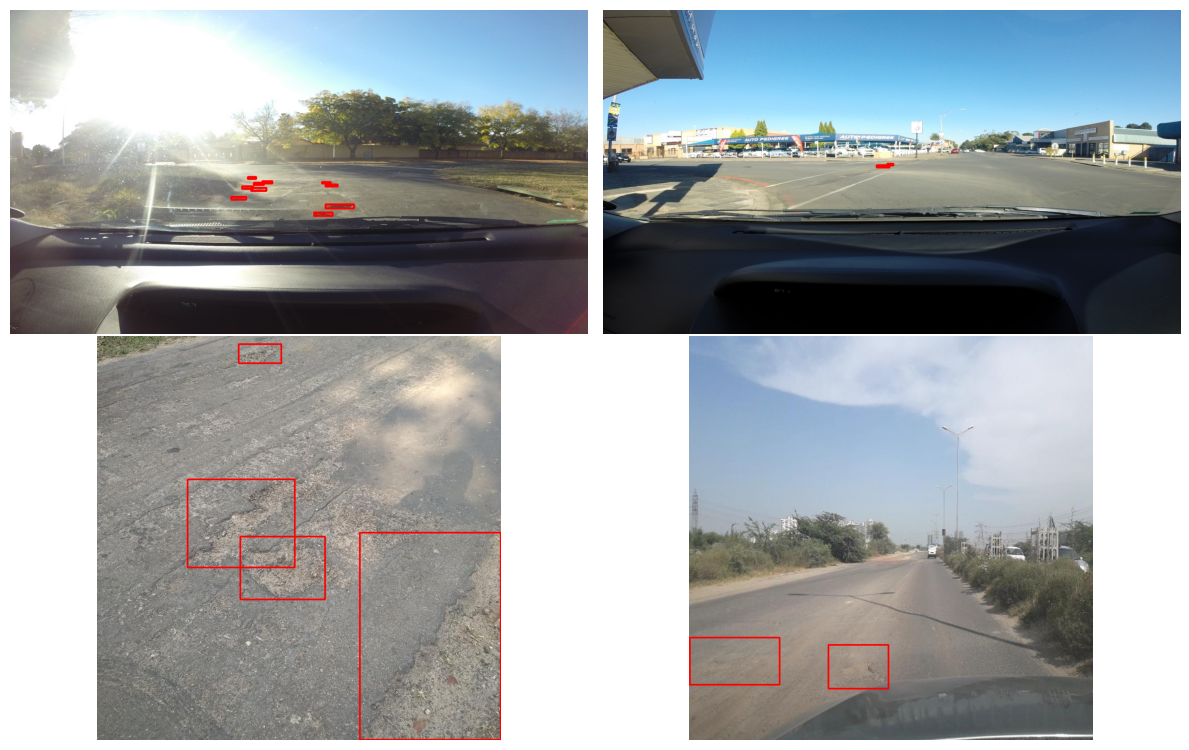

In [ ]:
# Визуализация нескольких обучающих изображений.
plot(
    image_paths='datasets/pothole_dataset_v8/train/images/',
    label_paths='datasets/pothole_dataset_v8/train/labels/',
    num_samples=4
)

## YAML-файл набора данных

In [ ]:
%%writefile pothole_v8.yaml
path: 'pothole_dataset_v8/'
train: 'train/images'
val: 'valid/images'

# class names
names:
  0: 'pothole'

Writing pothole_v8.yaml


## YOLOv8 Нано-тренинг

In [ ]:
# Пример обучения для 2 эпох
EPOCHS = 2
!yolo task=detect mode=train model=yolov8n.pt imgsz=1280 data=pothole_v8.yaml epochs={EPOCHS} batch=8 name=yolov8n_v8_50e

100% 6.23M/6.23M [00:00<00:00, 77.6MB/s]

Ultralytics YOLOv8.0.20 🚀 Python-3.10.12 torch-2.2.1+cu121 CUDA:0 (Tesla T4, 15102MiB)
yolo/engine/trainer: task=detect, mode=train, model=yolov8n.yaml, data=pothole_v8.yaml, epochs=2, patience=50, batch=8, imgsz=1280, save=True, cache=False, device=, workers=8, project=None, name=yolov8n_v8_50e, exist_ok=False, pretrained=False, optimizer=SGD, verbose=True, seed=0, deterministic=True, single_cls=False, image_weights=False, rect=False, cos_lr=False, close_mosaic=10, resume=False, overlap_mask=True, mask_ratio=4, dropout=False, val=True, save_json=False, save_hybrid=False, conf=0.001, iou=0.7, max_det=300, half=False, dnn=False, plots=True, source=ultralytics/assets/, show=False, save_txt=False, save_conf=False, save_crop=False, hide_labels=False, hide_conf=False, vid_stride=1, line_thickness=3, visualize=False, augment=False, agnostic_nms=False, classes=None, retina_masks=False, boxes=True, format=torchscript, keras=False, optimize=False, int8=

## Оценка проверочных изображений

In [ ]:
!yolo task=detect mode=val model=runs/detect/yolov8n_v8_50e/weights/best.pt name=yolov8n_eval data=pothole_v8.yaml

2024-04-03 05:16:27.716600: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-04-03 05:16:27.716657: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-04-03 05:16:27.718136: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-04-03 05:16:28.801793: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT
Ultralytics YOLOv8.0.20 🚀 Python-3.10.12 torch-2.2.1+cu121 CUDA:0 (Tesla T4, 15102MiB)
Model summary (fused): 168 layers, 3005843 parameters, 0 gradients, 8.1 GFLOPs
val: Scanning /content/datasets/pothole_dataset_v8/valid/labels.cache... 27

## Вывод проверочных изображений

In [ ]:
!yolo task=detect \
mode=predict \
model=runs/detect/yolov8n_v8_50e/weights/best.pt \
source=datasets/pothole_dataset_v8/valid/images \
imgsz=1280 \
name=yolov8n_v8_50e_infer1280 \
hide_labels=True

2024-04-03 05:17:00.786406: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-04-03 05:17:00.786463: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-04-03 05:17:00.787801: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-04-03 05:17:02.092143: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT
Ultralytics YOLOv8.0.20 🚀 Python-3.10.12 torch-2.2.1+cu121 CUDA:0 (Tesla T4, 15102MiB)
Model summary (fused): 168 layers, 3005843 parameters, 0 gradients, 8.1 GFLOPs
image 1/271 /content/datasets/pothole_dataset_v8/valid/images/G0011195.jpg:

## Визуализация результатов проверки

In [ ]:
# Визуализация изображений в сетке 2x2.

def visualize(result_dir, num_samples=4):
    """
    Function accepts a list of images and plots
    them in a 2x2 grid.
    """
    plt.figure(figsize=(24, 16))
    image_names = glob.glob(os.path.join(result_dir, '*.jpg'))
    random.shuffle(image_names)
    for i, image_name in enumerate(image_names):
        image = plt.imread(image_name)
        plt.subplot(2, 2, i+1)
        plt.imshow(image)
        plt.axis('off')
        plt.show()
        if i == num_samples-1:
            break
    plt.subplots_adjust(wspace=0.2, hspace=0.2)
    plt.tight_layout()
    plt.show()

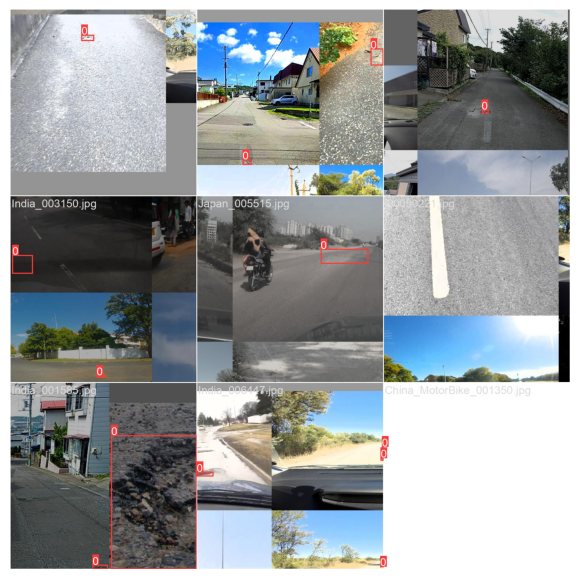

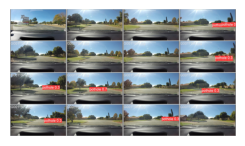

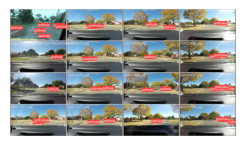

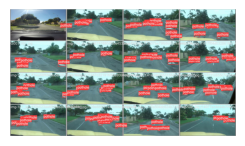

<Figure size 640x480 with 0 Axes>

In [ ]:
#visualize('runs/detect/yolov8n_v8_50e4_infer1280/')
visualize('runs/detect/yolov8n_v8_50e/')

#Задание
1. Найти датасет, размеченный под задачу детекции, вывести несколько изображений для примера с наложенными прямоугольными рамками, построенными по координатам из датасета
2. Обучить Yolo4 и Yolo8, сравнить результаты работы двух моделей.
3. Визуализировать результаты детекции на основе моделей.
3. Применить Yolo8 для детекции объектов на видео.